In [1]:
import os
_, current_folder_name = os.path.split(os.getcwd())
if current_folder_name == "notebooks":
    os.chdir("..")  
print(os.getcwd())  

/gpfs/data/oermannlab/users/ngok02/ModelCollapse/vae


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import copy

In [3]:
latent_dims = 20
lstm_dims = 128
K_vecs = 128
num_epochs = 30
batch_size = 256
collapse_size = 2560
patch_size = 4
emb_size = 32
height = width = 28
capacity = 64
learning_rate = 1e-3
variational_beta = 1
alpha = 0.1
gamma=15
beta=0.25
nl_stdev = 1
ng_stdev = 100
generations = 20

In [4]:
train_dataset = datasets.MNIST(root='../data', train = True, download = True, transform = ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='../data', train = False, download = True, transform = ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# device = 'cpu'
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Initial VAE

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar, sampleme=False):
        if self.training or sampleme:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence

In [7]:
def train_vae_gen(vae, train_dataloader, sample_vae=False, sample_from=None, grad_noise=False, debug=False):
    vae = vae.to(device)

    if debug:
        num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
        print('Number of parameters: %d' % num_params)

    optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

    vae.train()

    train_loss_avg = []

    if debug:
        print('Training ...')
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:

            image_batch = image_batch.to(device)

            if sample_vae:
                with torch.no_grad():
                    # image_batch = image_batch.to(device)
                    latent = torch.randn(image_batch.shape[0], latent_dims, device=device)
                    image_batch = sample_from.decoder(latent)

            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

            # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            if grad_noise:
                for p in vae.parameters():
                    p.grad = p.grad + torch.randn_like(p.grad) * ng_stdev

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        if debug:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [8]:
vae_init = VariationalAutoencoder().to(device)

In [9]:
train_vae_gen(vae_init, train_dataloader, debug=True)

Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 42969.433486
Epoch [2 / 30] average reconstruction error: 29567.045092
Epoch [3 / 30] average reconstruction error: 28129.578632
Epoch [4 / 30] average reconstruction error: 27459.705419
Epoch [5 / 30] average reconstruction error: 27058.983851
Epoch [6 / 30] average reconstruction error: 26796.025457
Epoch [7 / 30] average reconstruction error: 26585.648487
Epoch [8 / 30] average reconstruction error: 26439.375370
Epoch [9 / 30] average reconstruction error: 26293.514869
Epoch [10 / 30] average reconstruction error: 26190.988597
Epoch [11 / 30] average reconstruction error: 26077.582646
Epoch [12 / 30] average reconstruction error: 25995.210439
Epoch [13 / 30] average reconstruction error: 25926.420753
Epoch [14 / 30] average reconstruction error: 25846.682073
Epoch [15 / 30] average reconstruction error: 25786.058910
Epoch [16 / 30] average reconstruction error: 25717.779613
Epoch [17 / 30] average

# VQVAE

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=latent_dims, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.conv2 = nn.ConvTranspose2d(in_channels=latent_dims, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VQVariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VQVariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.vq = VectorQuantizer()

    def forward(self, x):
        latent = self.encoder(x)
        vq_loss, encoding_indices, quantized = self.vq(latent)
        x_recon = self.decoder(quantized)
        return vq_loss, encoding_indices, x_recon

    def latent_sample(self, mu, logvar, sampleme=False):
        if self.training or sampleme:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

class VectorQuantizer(nn.Module):
    def __init__(self):
        super(VectorQuantizer, self).__init__()
        self.codebook = nn.Embedding(num_embeddings=K_vecs, embedding_dim=latent_dims)
        self.embedding_dim = latent_dims

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.shape

        flat_input = x.view(-1, 1, self.embedding_dim)

        distances = (flat_input - self.codebook.weight.unsqueeze(0)).pow(2).mean(2)

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        quantized = self.codebook(encoding_indices).view(input_shape)

        codebook_loss = F.mse_loss(quantized, x.detach())
        commitment_loss = F.mse_loss(quantized.detach(), x)
        loss = codebook_loss + beta * commitment_loss

        if self.training:
            quantized = x + (quantized - x).detach()

        return loss, encoding_indices, quantized.permute(0, 3, 1, 2).contiguous()

def vqvae_loss(x, recon_x, vq_loss):
    recon_loss = F.mse_loss(recon_x, x)
    return recon_loss + vq_loss

In [11]:
def train_vqvae(vae, train_dataloader, debug=False):
    vae = vae.to(device)

    if debug:
        num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
        print('Number of parameters: %d' % num_params)

    optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

    vae.train()

    train_loss_avg = []

    if debug:
        print('Training ...')
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:

            image_batch = image_batch.to(device)

            # vae reconstruction
            vq_loss, _, image_batch_recon = vae(image_batch)

            # reconstruction error
            loss = vqvae_loss(image_batch, image_batch_recon, vq_loss)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        if debug:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [12]:
vqvae = VQVariationalAutoencoder().to(device)

In [13]:
train_vqvae(vqvae, train_dataloader, debug=True)

Number of parameters: 45717
Training ...
Epoch [1 / 30] average reconstruction error: 0.265213
Epoch [2 / 30] average reconstruction error: 0.141115
Epoch [3 / 30] average reconstruction error: 0.101385
Epoch [4 / 30] average reconstruction error: 0.082538
Epoch [5 / 30] average reconstruction error: 0.057201
Epoch [6 / 30] average reconstruction error: 0.042420
Epoch [7 / 30] average reconstruction error: 0.033617
Epoch [8 / 30] average reconstruction error: 0.030707
Epoch [9 / 30] average reconstruction error: 0.027611
Epoch [10 / 30] average reconstruction error: 0.025824
Epoch [11 / 30] average reconstruction error: 0.024806
Epoch [12 / 30] average reconstruction error: 0.024292
Epoch [13 / 30] average reconstruction error: 0.023688
Epoch [14 / 30] average reconstruction error: 0.023327
Epoch [15 / 30] average reconstruction error: 0.023286
Epoch [16 / 30] average reconstruction error: 0.023269
Epoch [17 / 30] average reconstruction error: 0.023266
Epoch [18 / 30] average reconstru

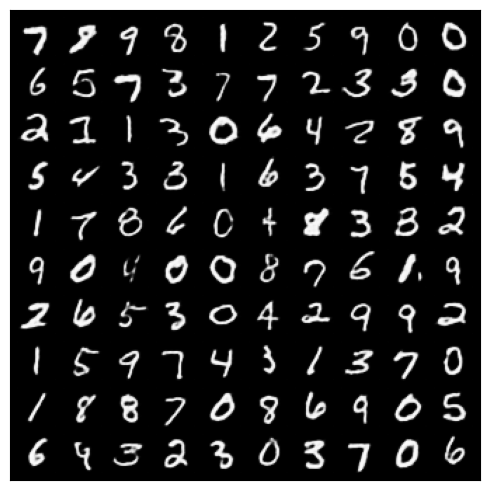

In [14]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

for image_batch, _ in test_dataloader:
    image_batch = image_batch.to(device)
    _, _, img_recon = vqvae(image_batch)
    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(make_grid(img_recon.cpu().data[:100],10,5))
    # plt.show()
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    break

In [15]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=K_vecs+1, embedding_dim=latent_dims)
        self.lstm = nn.LSTM(input_size=latent_dims, hidden_size=lstm_dims, batch_first=True)
        self.fc1 = nn.Linear(lstm_dims, lstm_dims // 4)
        self.fc2 = nn.Linear(lstm_dims // 4, K_vecs+1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, sos=None):
        x = self.embedding(x)
        logits, _ = self.lstm(x)
        logits = F.relu(self.fc1(logits))
        logits = self.fc2(logits)
        logits = logits[:, -1, :]
        out = self.softmax(logits)
        return logits, out

In [16]:
def train_lstm(vae, lstm, train_dataloader, debug=False):
    vae = vae.to(device)
    lstm = lstm.to(device)

    if debug:
        num_params = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
        print('Number of parameters: %d' % num_params)

    optimizer = torch.optim.Adam(params=lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

    lstm.train()

    train_loss_avg = []

    if debug:
        print('Training ...')
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:

            image_batch = image_batch.to(device)

            # vae reconstruction
            _, encoding_indices, _ = vae(image_batch)

            encoding_indices = encoding_indices.view((image_batch.shape[0], -1)).detach()
            B, L = encoding_indices.shape

            sos = K_vecs * torch.ones(B, 1).long().to(device)

            encoding_indices = torch.cat((sos, encoding_indices), dim=1)

            for i in range(1, L+1):
                input_sequence = encoding_indices[:,:i]
                target = encoding_indices[:,i]
                target = F.one_hot(target, num_classes=K_vecs+1).float()

                logits, _ = lstm(input_sequence)

                loss = F.cross_entropy(logits, target)

                # backpropagation
                optimizer.zero_grad()
                loss.backward()
    
                # one step of the optmizer (using the gradients from backpropagation)
                optimizer.step()
    
                train_loss_avg[-1] += loss.item()
                num_batches += 1

        train_loss_avg[-1] /= num_batches
        if debug:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [17]:
lstm = LSTM()
lstm = lstm.to(device)

In [18]:
train_lstm(vqvae, lstm, train_dataloader, debug=True)

Number of parameters: 87765
Training ...
Epoch [1 / 30] average reconstruction error: 1.329094
Epoch [2 / 30] average reconstruction error: 1.032927
Epoch [4 / 30] average reconstruction error: 0.938840
Epoch [5 / 30] average reconstruction error: 0.918707
Epoch [6 / 30] average reconstruction error: 0.905773
Epoch [8 / 30] average reconstruction error: 0.888988
Epoch [9 / 30] average reconstruction error: 0.883470
Epoch [10 / 30] average reconstruction error: 0.878476
Epoch [11 / 30] average reconstruction error: 0.874941
Epoch [12 / 30] average reconstruction error: 0.872413
Epoch [13 / 30] average reconstruction error: 0.870472
Epoch [14 / 30] average reconstruction error: 0.867714
Epoch [15 / 30] average reconstruction error: 0.865156
Epoch [16 / 30] average reconstruction error: 0.864450
Epoch [17 / 30] average reconstruction error: 0.862069
Epoch [18 / 30] average reconstruction error: 0.860646
Epoch [19 / 30] average reconstruction error: 0.859475
Epoch [20 / 30] average reconst

In [19]:
def generate_latent(lstm, vqvae, codebook):
    indices = K_vecs * torch.ones(1, 1).long().to(device)
    for i in range(49):
        _, token = lstm(indices)
        token = token.squeeze(0)
        idx = K_vecs
        while idx >= K_vecs:
            idx = torch.multinomial(token, 1)
        indices = torch.cat((indices, idx.unsqueeze(0)), dim=1)
    
    latent = torch.empty(0, latent_dims).to(device)
    for i in indices[0,1:]:
        latent = torch.cat((latent, codebook(i).unsqueeze(0)))
    latent = latent.view(1, 7, 7, -1)
    latent = latent.permute(0, 3, 1, 2)
    return latent

def generate_latent_batch(lstm, vqvae, codebook, n):
    latent_batch = torch.tensor([]).to(device)
    for i in range(n):
        latent_batch = torch.cat((latent_batch, generate_latent(lstm, vqvae, codebook)))
    return latent_batch

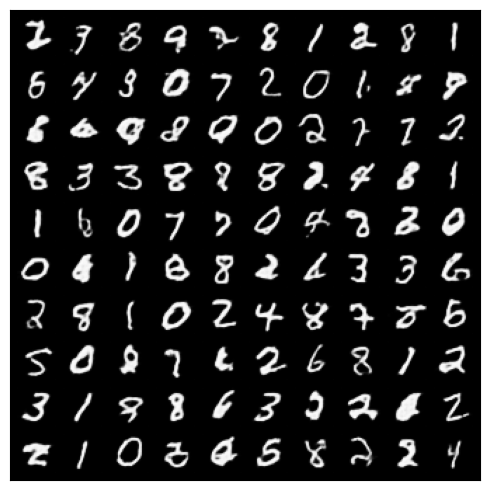

In [20]:
latent_batch = generate_latent_batch(lstm, vqvae, codebook=vqvae.vq.codebook, n=100)
samples = vqvae.decoder(latent_batch)
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(samples.detach().cpu(),10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()

In [21]:
def create_dataloader(tensor, size, batch_size, targets=None):
    if targets is not None:
        dataset = TensorDataset(tensor, targets)
    else:
        dataset = TensorDataset(tensor, torch.zeros(size).to(device))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def combine_dataloader(tensor_a, dataset_b, size, batch_size, ab_ratio):
    dataset_a = TensorDataset(tensor_a, torch.zeros(size).to(device))
    an = int(ab_ratio * size)
    bn = size - an
    dataset_a = partition_dataset(dataset_a, an)
    dataset_b = partition_dataset(dataset_b, bn) 
    dataset_c = ConcatDataset([dataset_a, dataset_b])
    return DataLoader(dataset_c, batch_size=batch_size, shuffle=True)

def record_values(vae_init, vae_start, vae, samples, loss, lstm, codebook_samples=None, codebook_loss=None, persistent_codebook=False, selective_codebook=False):
    vae.eval()
    lstm.eval()
    vae_init.eval()
    vae_start.eval()

    if persistent_codebook:
        latent = generate_latent_batch(lstm, vae, vae_start.vq.codebook, collapse_size)
    elif codebook_samples is not None and codebook_loss is not None:
        latent = generate_latent_batch(lstm, vae, vae.vq.codebook, collapse_size)
        codebook_latent = generate_latent_batch(lstm, vae, vae_start.vq.codebook, collapse_size)
        
        codebook_img_recon = vae.decoder(codebook_latent).clone().detach().to(device)
        codebook_samples.append(codebook_img_recon.data[:100].cpu())
        
        codebook_x_recon, codebook_latent_mu, codebook_latent_logvar = vae_init(codebook_img_recon)
        codebook_loss.append(vae_loss(codebook_x_recon, codebook_img_recon, codebook_latent_mu, codebook_latent_logvar))
    elif selective_codebook:
        codebook_indices = torch.randint(0, 2, (K_vecs,))
        selected_codebook = torch.where(
            codebook_indices.bool().unsqueeze(1),
            vae.vq.codebook,
            vae_start.vq.codebook
        )
        latent = generate_latent_batch(lstm, vae, selected_codebook, collapse_size)
    else:
        latent = generate_latent_batch(lstm, vae, vae.vq.codebook, collapse_size)
        
    img_recon = vae.decoder(latent).clone().detach().to(device)
    samples.append(img_recon.data[:100].cpu())
    
    x_recon, latent_mu, latent_logvar = vae_init(img_recon)
    loss.append(vae_loss(x_recon, img_recon, latent_mu, latent_logvar))
    
    return img_recon

def collapse(vae_init, vae_start, lstm, debug=False, generations=20, persistent_codebook=False, selective_codebook=False):
    vae = copy.deepcopy(vae_start).to(device)
    samples = []
    loss = []
    codebook_samples = []
    codebook_loss = []

    for i in range(generations):
        if debug:
            print(f"Generation {i}")

        img_recon = record_values(vae_init, vae_start, vae, samples, loss, lstm, codebook_samples, codebook_loss, persistent_codebook=persistent_codebook, selective_codebook=selective_codebook)

        train_dataloader = create_dataloader(img_recon, collapse_size, batch_size)
    
        train_vqvae(vae, train_dataloader)
    
    record_values(vae_init, vae_start, vae, samples, loss, lstm, codebook_samples, codebook_loss, persistent_codebook=persistent_codebook, selective_codebook=selective_codebook)

    return vae, samples, loss, codebook_samples, codebook_loss

def vqvae_lstm_collapse(vae_init, vae_start, lstm, debug=False, generations=20, persistent_codebook=False, selective_codebook=False):
    vae = copy.deepcopy(vae_start).to(device)
    lstm = copy.deepcopy(lstm).to(device)

    samples = []
    loss = []
    codebook_samples = []
    codebook_loss = []

    for i in range(generations):
        if debug:
            print(f"Generation {i}")

        img_recon = record_values(vae_init, vae_start, vae, samples, loss, lstm, codebook_samples, codebook_loss, persistent_codebook=persistent_codebook, selective_codebook=selective_codebook)

        train_dataloader = create_dataloader(img_recon, collapse_size, batch_size)
    
        train_vqvae(vae, train_dataloader)
        train_lstm(vae, lstm, train_dataloader)
    
    record_values(vae_init, vae_start, vae, samples, loss, lstm, codebook_samples, codebook_loss, persistent_codebook=persistent_codebook, selective_codebook=selective_codebook)

    return vae, lstm, samples, loss, codebook_samples, codebook_loss

# Collapse models

In [ ]:
vqvae_collapsed, vqvae_samples, vqvae_loss_data, codebook_vqvae_samples, codebook_vqvae_loss_data = collapse(vae_init, vqvae, lstm, debug=True, generations=50)
torch.save(vqvae_samples, 'outputs/tensors/samples_vqvae.pt')
torch.save(vqvae_loss_data, 'outputs/tensors/loss_vqvae.pt')
torch.save(codebook_vqvae_samples, 'outputs/tensors/samples_codebook_vqvae.pt')
torch.save(codebook_vqvae_loss_data, 'outputs/tensors/loss_codebook_vqvae.pt')

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49


In [23]:
torch.save(vqvae, 'outputs/models/vqvae.pt')
torch.save(vqvae_collapsed, 'outputs/models/vqvae_collapsed.pt')
torch.save(lstm, 'outputs/models/lstm.pt')

In [ ]:
vqvae_lstm, lstm_collapsed, vqvae_lstm_samples, vqvae_lstm_loss, vqvae_lstm_codebook_samples, vqvae_lstm_codebook_loss = vqvae_lstm_collapse(vae_init, vqvae, lstm, debug=True, generations=50)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49


In [ ]:
torch.save(vqvae_lstm_samples, 'outputs/tensors/samples_vqvae_lstm.pt')
torch.save(vqvae_lstm_loss, 'outputs/tensors/loss_vqvae_lstm.pt')
torch.save(vqvae_lstm_codebook_samples, 'outputs/tensors/samples_codebook_vqvae_lstm.pt')
torch.save(vqvae_lstm_codebook_loss, 'outputs/tensors/loss_codebook_vqvae_lstm.pt')

In [24]:
torch.save(vqvae_lstm, 'outputs/models/vqvae_lstm_collapsed.pt')
torch.save(lstm_collapsed, 'outputs/models/lstm_collapsed.pt')

In [25]:
_, persistent_codebook_samples, persistent_codebook_loss, _, _ = collapse(vae_init, vqvae, lstm, debug=True, generations=50, persistent_codebook=True)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49


In [26]:
torch.save(persistent_codebook_samples, 'outputs/tensors/samples_persistent_codebook_vqvae.pt')
torch.save(persistent_codebook_loss, 'outputs/tensors/loss_persistent_codebook_vqvae.pt')

In [28]:
_, _, persistent_codebook_lstm_samples, persistent_codebook_lstm_loss, _, _ = vqvae_lstm_collapse(vae_init, vqvae, lstm, debug=True, generations=50, persistent_codebook=True)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49


In [29]:
torch.save(persistent_codebook_lstm_samples, 'outputs/tensors/samples_persistent_codebook_vqvae_lstm.pt')
torch.save(persistent_codebook_lstm_loss, 'outputs/tensors/loss_persistent_codebook_vqvae_lstm.pt')

In [22]:
_, selective_codebook_samples, selective_codebook_loss, _, _ = collapse(vae_init, vqvae, lstm, debug=True, generations=50, selective_codebook=True)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49


In [23]:
torch.save(selective_codebook_samples, 'outputs/tensors/samples_selective_codebook_vqvae.pt')
torch.save(selective_codebook_loss, 'outputs/tensors/loss_selective_codebook_vqvae.pt')

In [24]:
_, _, selective_codebook_lstm_samples, selective_codebook_lstm_loss, _, _ = vqvae_lstm_collapse(vae_init, vqvae, lstm, debug=True, generations=50, selective_codebook=True)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19
Generation 20
Generation 21
Generation 22
Generation 23
Generation 24
Generation 25
Generation 26
Generation 27
Generation 28
Generation 29
Generation 30
Generation 31
Generation 32
Generation 33
Generation 34
Generation 35
Generation 36
Generation 37
Generation 38
Generation 39
Generation 40
Generation 41
Generation 42
Generation 43
Generation 44
Generation 45
Generation 46
Generation 47
Generation 48
Generation 49


In [25]:
torch.save(selective_codebook_lstm_samples, 'outputs/tensors/samples_selective_codebook_vqvae_lstm.pt')
torch.save(selective_codebook_lstm_loss, 'outputs/tensors/loss_selective_codebook_vqvae_lstm.pt')

# Load models

In [30]:
vqvae = torch.load('outputs/models/vqvae.pt', weights_only=False)
vqvae_collapsed = torch.load('outputs/models/vqvae_collapsed.pt', weights_only=False)
lstm = torch.load('outputs/models/lstm.pt', weights_only=False)
vqvae_lstm = torch.load('outputs/models/vqvae_lstm_collapsed.pt', weights_only=False)
lstm_collapsed = torch.load('outputs/models/lstm_collapsed.pt', weights_only=False)

In [26]:
vqvae_samples = torch.load('outputs/tensors/samples_vqvae.pt')
vqvae_loss_data = torch.load('outputs/tensors/loss_vqvae.pt')
codebook_vqvae_samples = torch.load('outputs/tensors/samples_vqvae_codebook.pt')
codebook_vqvae_loss_data = torch.load('outputs/tensors/loss_vqvae_codebook.pt')

vqvae_lstm_samples = torch.load('outputs/tensors/samples_vqvae_lstm.pt')
vqvae_lstm_loss = torch.load('outputs/tensors/loss_vqvae_lstm.pt')
vqvae_lstm_codebook_samples = torch.load('outputs/tensors/samples_vqvae_lstm_codebook.pt')
vqvae_lstm_codebook_loss = torch.load('outputs/tensors/loss_vqvae_lstm_codebook.pt')

persistent_codebook_samples = torch.load('outputs/tensors/samples_persistent_codebook_vqvae.pt')
persistent_codebook_loss = torch.load('outputs/tensors/loss_persistent_codebook_vqvae.pt')
persistent_codebook_lstm_samples = torch.load('outputs/tensors/samples_persistent_codebook_vqvae_lstm.pt')
persistent_codebook_lstm_loss = torch.load('outputs/tensors/loss_persistent_codebook_vqvae_lstm.pt')

selective_codebook_samples = torch.load('outputs/tensors/samples_selective_codebook_vqvae.pt')
selective_codebook_loss = torch.load('outputs/tensors/loss_selective_codebook_vqvae.pt')
selective_codebook_lstm_samples = torch.load('outputs/tensors/samples_selective_codebook_vqvae_lstm.pt')
selective_codebook_lstm_loss = torch.load('outputs/tensors/loss_selective_codebook_vqvae_lstm.pt')

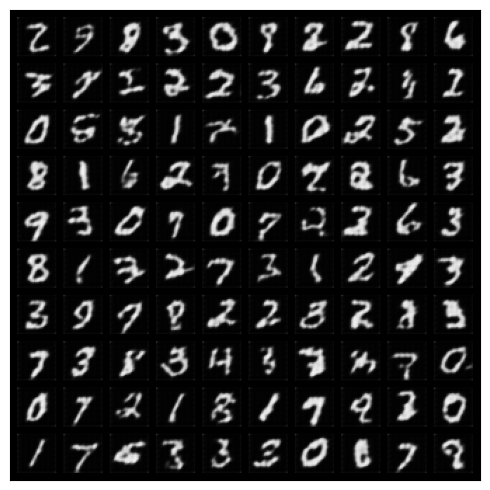

In [27]:
# latent_batch = generate_latent_batch(lstm, vqvae_collapsed, codebook=vqvae.vq.codebook, n=100)
# generated_samples = vqvae_collapsed.decoder(latent_batch)
fig, ax = plt.subplots(figsize=(5, 5))
# show_image(make_grid(generated_samples.detach().cpu(),10,5))
show_image(make_grid(selective_codebook_samples[50].detach().cpu(),10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen50_vqvae_selective_codebook.png')

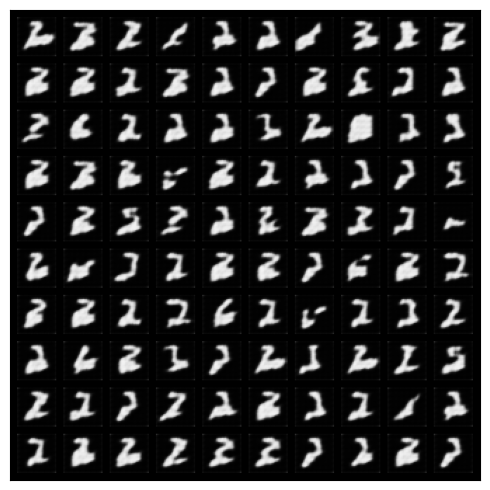

In [28]:
# latent_batch = generate_latent_batch(lstm, vqvae_collapsed, codebook=vqvae.vq.codebook, n=100)
# generated_samples = vqvae_collapsed.decoder(latent_batch)
fig, ax = plt.subplots(figsize=(5, 5))
# show_image(make_grid(generated_samples.detach().cpu(),10,5))
show_image(make_grid(selective_codebook_lstm_samples[50].detach().cpu(),10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen50_vqvae_lstm_selective_codebook.png')

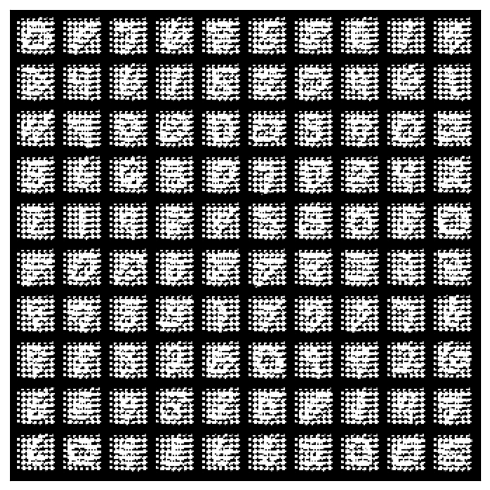

In [32]:
# latent_batch = generate_latent_batch(lstm, vqvae_collapsed, codebook=vqvae.vq.codebook, n=100)
# generated_samples = vqvae_collapsed.decoder(latent_batch)
fig, ax = plt.subplots(figsize=(5, 5))
# show_image(make_grid(generated_samples.detach().cpu(),10,5))
show_image(make_grid(persistent_codebook_samples[50].detach().cpu(),10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen50_vqvae_persistent_codebook.png')

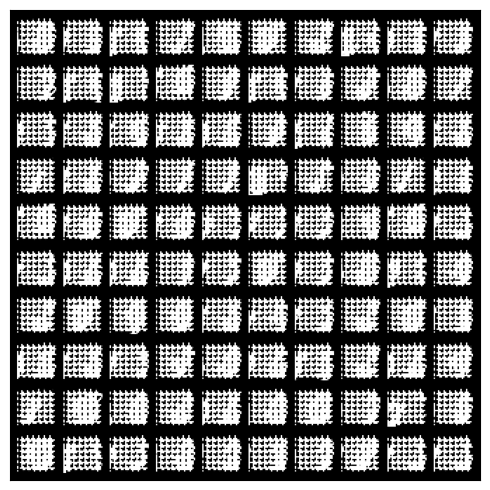

In [33]:
# latent_batch = generate_latent_batch(lstm, vqvae_collapsed, codebook=vqvae.vq.codebook, n=100)
# generated_samples = vqvae_collapsed.decoder(latent_batch)
fig, ax = plt.subplots(figsize=(5, 5))
# show_image(make_grid(generated_samples.detach().cpu(),10,5))
show_image(make_grid(persistent_codebook_lstm_samples[50].detach().cpu(),10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen50_vqvae_lstm_persistent_codebook.png')

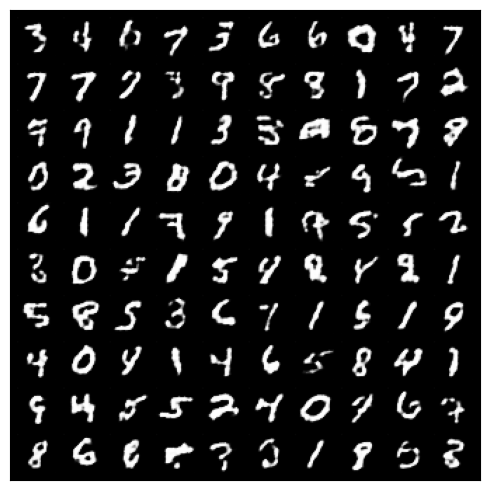

In [27]:
# latent_batch = generate_latent_batch(lstm, vqvae_collapsed, codebook=vqvae.vq.codebook, n=100)
# generated_samples = vqvae_collapsed.decoder(latent_batch)
fig, ax = plt.subplots(figsize=(5, 5))
# show_image(make_grid(generated_samples.detach().cpu(),10,5))
show_image(make_grid(codebook_vqvae_samples[50].detach().cpu(),10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen50_vqvae_codebook.png')

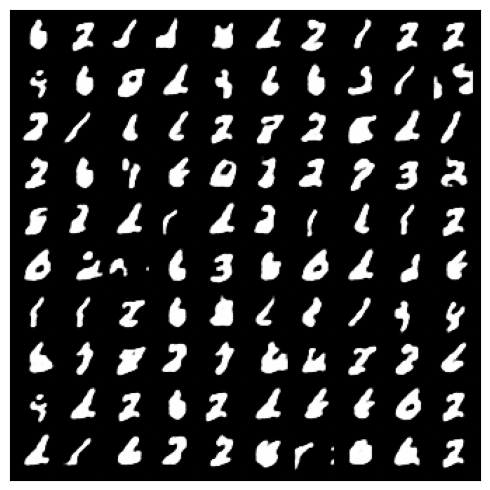

In [28]:
# latent_batch = generate_latent_batch(lstm, vqvae_collapsed, codebook=vqvae.vq.codebook, n=100)
# generated_samples = vqvae_collapsed.decoder(latent_batch)
fig, ax = plt.subplots(figsize=(5, 5))
# show_image(make_grid(generated_samples.detach().cpu(),10,5))
show_image(make_grid(vqvae_lstm_codebook_samples[50].detach().cpu(),10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen50_vqvae_lstm_codebook.png')

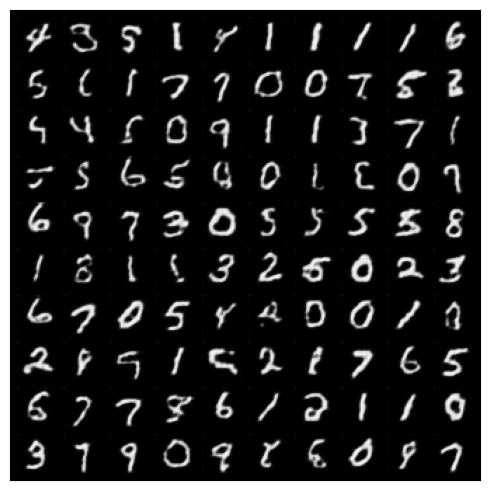

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(vqvae_samples[20][:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen20_vqvae.png')

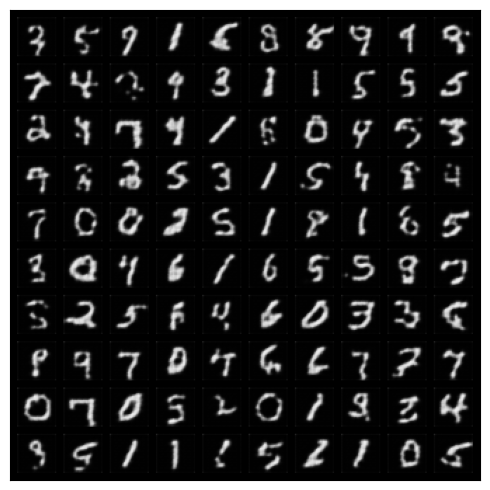

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(vqvae_samples[50][:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen50_vqvae.png')

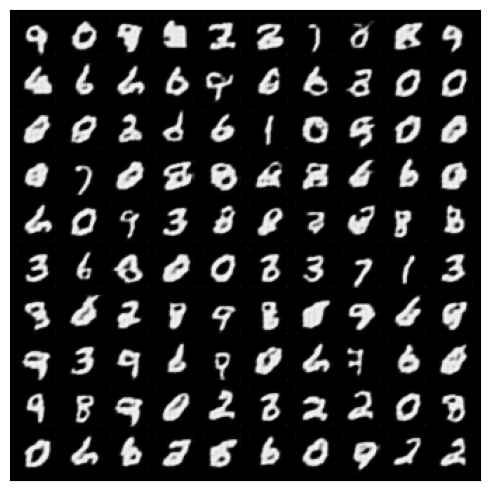

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(vqvae_lstm_samples[20][:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen20_vqvae_lstm.png')

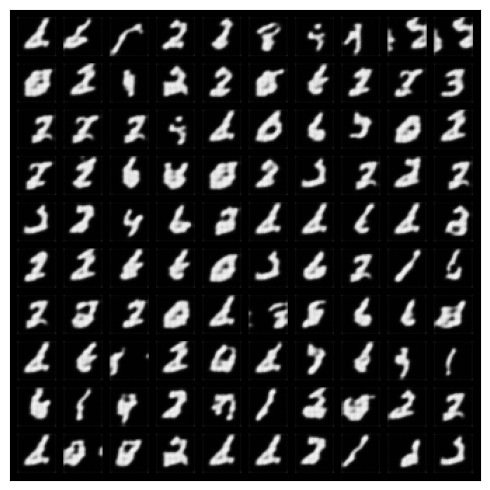

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(vqvae_lstm_samples[50][:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('images/gen50_vqvae_lstm.png')

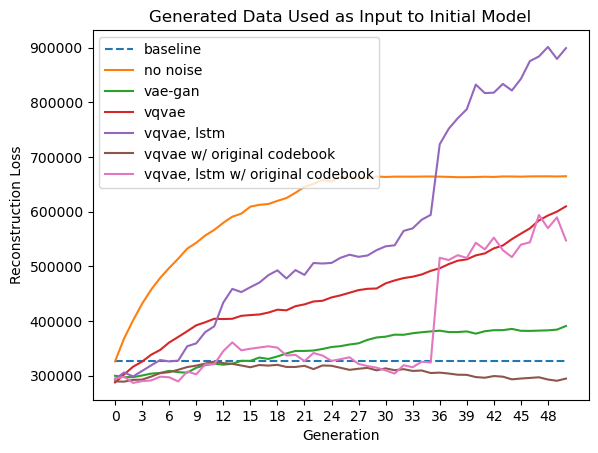

In [37]:
generations = 50
yscale = "linear"
losses = ['nonoise_50gen', 'gan_50gen', 'vqvae', 'vqvae_lstm', 'vqvae_codebook', 'vqvae_lstm_codebook', 'selective_codebook_vqvae', 'selective_codebook_vqvae_lstm'] #, 'persistent_codebook_vqvae', 'persistent_codebook_vqvae_lstm']
labels = ['no noise', 'vae-gan', 'vqvae', 'vqvae, lstm', 'vqvae w/ original codebook', 'vqvae, lstm w/ original codebook', 'vqvae w/ original codebook', 'vqvae, lstm w/ original codebook'] #, 'vqvae w/ persistent codebook', 'vqvae, lstm w/ persistent codebook']
for i, suffix in enumerate(losses):
    input_path = os.path.join('outputs/tensors/', f"loss_{suffix}.pt")
    loss = torch.load(input_path, map_location=torch.device('cpu'))
    if i == 0:
        baseline = loss[0].item()
        plt.plot([baseline for _ in range(generations + 1)], label="baseline", linestyle="dashed")
    plt.plot([l.item() for l in loss], label=labels[i])

plt.legend()
plt.ylabel("Reconstruction Loss")
plt.xlabel("Generation")
plt.title("Generated Data Used as Input to Initial Model")
plt.xticks(range(0, generations + 1, (generations + 10) // 20))
plt.yscale(yscale)

plt.savefig('images/loss_init_vqvae.png')